# Data Augmentation

Este notebook implementa el aumento de datos para señales sísmicas. Para cada señal original, se generan dos versiones aumentadas usando:

1. Modulación de amplitud con ventana grande (2000 muestras)
2. Desplazamiento temporal (15%) + ruido suave (4%)

El objetivo es triplicar el conjunto de datos manteniendo las características importantes de las señales sísmicas.

In [27]:
import numpy as np
from scipy import signal
import pandas as pd
import os
from obspy import read
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
# Paths
train_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training'
testing_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/testing'
train_csv_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/raw/VT_P_training.csv'
augmented_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented'
val_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/val'
train_augment_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/train'
# Crear directorio para datos aumentados si no existe
if not os.path.exists(augmented_data_path):
    os.makedirs(augmented_data_path)

# Leer CSV con tiempos de llegada
df = pd.read_csv(train_csv_path) 

In [90]:
def amplitude_modulation(signal_data, window_size=2000):
    """Aplica modulación de amplitud variable en el tiempo.
    Args:
        signal_data: Señal original
        window_size: Tamaño de la ventana para la modulación
    Returns:
        array: Señal modulada"""
    envelope = np.ones_like(signal_data)
    num_windows = len(signal_data) // window_size
    for i in range(num_windows):
        start = i * window_size
        end = start + window_size
        envelope[start:end] *= np.random.uniform(0.8, 1.2)
    # Suavizar las transiciones entre ventanas usando scipy.signal
    envelope = signal.savgol_filter(envelope, window_length=501, polyorder=3)
    return signal_data * envelope

def time_shift(signal_data, sample_rate, p_arrival_time, shift_range=0.15):
    """Desplaza la señal en tiempo preservando el tiempo de llegada P.
    Args:
        signal_data: Señal original
        sample_rate: Frecuencia de muestreo
        p_arrival_time: Tiempo de llegada P en segundos
        shift_range: Rango máximo de desplazamiento como fracción de la longitud
    Returns:
        tuple: (señal desplazada, nuevo tiempo P)"""
    # Convertir el tiempo P a muestras
    p_sample = int(p_arrival_time * sample_rate)
    
    # Calcular el máximo desplazamiento permitido
    max_shift = int(len(signal_data) * shift_range)
    
    # Generar un desplazamiento aleatorio que mantenga el tiempo P dentro de la señal
    min_shift = -min(p_sample, max_shift)  # No desplazar más allá del inicio
    max_shift = min(len(signal_data) - p_sample, max_shift)  # No desplazar más allá del final
    shift = int(np.random.uniform(min_shift, max_shift))
    
    # Aplicar el desplazamiento
    shifted_signal = np.roll(signal_data, shift)
    new_p_time = p_arrival_time + (shift / sample_rate)
    
    return shifted_signal, new_p_time

def add_noise(signal_data, noise_level=0.02):
    """Añade ruido gaussiano a la señal.
    Args:
        signal_data: Señal original
        noise_level: Nivel de ruido (proporción de la desviación estándar de la señal)
    Returns:
        array: Señal con ruido"""
    noise = np.random.normal(0, noise_level * np.std(signal_data), len(signal_data))
    return signal_data + noise

def augment_seismic_data(signal_data, sample_rate, p_arrival_time):
    """Aplica técnicas seleccionadas de aumento de datos a la señal sísmica.
    Args:
        signal_data: Señal sísmica original
        sample_rate: Frecuencia de muestreo
        p_arrival_time: Tiempo de llegada P en segundos
    Returns:
        tuple: (señales aumentadas, nuevos tiempos de llegada)"""
    augmented_signals = []
    augmented_arrivals = []
    
    # 1. Modulación de amplitud con ventana grande y suavizado
    signal_amp = amplitude_modulation(signal_data.copy())
    augmented_signals.append(signal_amp)
    augmented_arrivals.append(p_arrival_time)
    
    # 2. Desplazamiento temporal + ruido suave
    signal_shifted, new_p_time = time_shift(signal_data.copy(), sample_rate, p_arrival_time)
    signal_shifted = add_noise(signal_shifted)
    augmented_signals.append(signal_shifted)
    augmented_arrivals.append(new_p_time)
    
    return np.array(augmented_signals), np.array(augmented_arrivals)

In [91]:
def get_relative_p_time(tr, absolute_p_time):
    """Convierte el tiempo absoluto de llegada P en tiempo relativo dentro de la señal.
    Args:
        tr: Trace object de ObsPy
        absolute_p_time: Tiempo absoluto de llegada P en segundos
    Returns:
        float: Tiempo relativo de llegada P en segundos"""
    start_time = tr.stats.starttime.timestamp
    return absolute_p_time - start_time

def augment_single_file(mseed_file, absolute_p_time):
    """Aplica aumento de datos a un archivo sísmico y guarda las versiones aumentadas.
    Args:
        mseed_file: Nombre del archivo MSEED a aumentar
        absolute_p_time: Tiempo absoluto de llegada de la onda P en segundos
    Returns:
        int: Número de señales aumentadas generadas"""
    # Leer la señal original
    file_path = os.path.join(train_data_path, mseed_file)
    st = read(file_path)
    tr = st[0]
    
    # Convertir tiempo P absoluto a relativo
    relative_p_time = get_relative_p_time(tr, absolute_p_time)
    
    # Generar señales aumentadas
    augmented_signals, augmented_arrivals = augment_seismic_data(
        tr.data,
        tr.stats.sampling_rate,
        relative_p_time
    )

    # Guardar cada señal aumentada
    for i, (aug_signal, aug_arrival) in enumerate(zip(augmented_signals, augmented_arrivals)):
        aug_st = st.copy()
        aug_st[0].data = aug_signal
        
        base_name = os.path.splitext(mseed_file)[0]
        aug_filename = f"{base_name}_aug{i+1}.mseed"
        output_path = os.path.join(augmented_data_path, aug_filename)
        
        aug_st.write(output_path, format='MSEED')
    
    return len(augmented_signals)

In [92]:
def plot_augmentation_comparison(mseed_file):
    """Visualiza la señal original y sus dos versiones aumentadas.
    Args:
        mseed_file: Nombre del archivo MSEED a analizar"""
    # Leer señal original
    file_path = os.path.join(train_data_path, mseed_file)
    st = read(file_path)
    tr = st[0]
    
    # Obtener y convertir tiempo P
    file_id = int(mseed_file.split('.')[0])
    row = df[df['archivo'] == file_id]
    if row.empty:
        print(f"No se encontró el tiempo P para {mseed_file}")
        return
        
    p_time = row.iloc[0]['lec_p']
    relative_p_time = get_relative_p_time(tr, p_time)
    
    # Generar señales aumentadas
    augmented_signals, augmented_arrivals = augment_seismic_data(
        tr.data, tr.stats.sampling_rate, relative_p_time)

    # Crear vector de tiempo
    times = np.arange(len(tr.data)) / tr.stats.sampling_rate

    # Ajustar el rango de visualización alrededor del tiempo P
    window = 50  # segundos antes y después del tiempo P
    start_idx = max(0, int((relative_p_time - window) * tr.stats.sampling_rate))
    end_idx = min(len(times) - 1, int((relative_p_time + window) * tr.stats.sampling_rate))

    # Configurar subplots con más altura para mejor visualización
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    fig.suptitle(f'Comparación de señales - {mseed_file}\nVentana de ±50 segundos alrededor del tiempo P', y=0.95)

    # Graficar señales con zoom alrededor del tiempo P
    ax1.plot(times[start_idx:end_idx+1], tr.data[start_idx:end_idx+1], 'b-', label='Original')
    ax1.axvline(x=relative_p_time, color='r', linestyle='--', label='Llegada P')
    ax1.set_title('Señal Original')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(times[start_idx:end_idx+1], augmented_signals[0][start_idx:end_idx+1], 'g-', 
             label='Modulación de amplitud')
    ax2.axvline(x=augmented_arrivals[0], color='r', linestyle='--', label='Llegada P')
    ax2.set_title('Aumentada: Modulación de amplitud')
    ax2.grid(True)
    ax2.legend()

    ax3.plot(times[start_idx:end_idx+1], augmented_signals[1][start_idx:end_idx+1], 'm-', 
             label='Desplazamiento + ruido')
    ax3.axvline(x=augmented_arrivals[1], color='r', linestyle='--', label='Llegada P')
    ax3.set_title('Aumentada: Desplazamiento + ruido')
    ax3.grid(True)
    ax3.legend()

    for ax in (ax1, ax2, ax3):
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')

    plt.tight_layout()
    plt.show()

    # Imprimir estadísticas e información del desplazamiento
    print("\nEstadísticas de las señales:")
    print("Original:")
    print(f"  Media: {np.mean(tr.data):.3f}")
    print(f"  Desviación estándar: {np.std(tr.data):.3f}")
    print(f"  Tiempo P: {relative_p_time:.2f} s")
    print("\nModulación de amplitud:")
    print(f"  Media: {np.mean(augmented_signals[0]):.3f}")
    print(f"  Desviación estándar: {np.std(augmented_signals[0]):.3f}")
    print(f"  Tiempo P: {augmented_arrivals[0]:.2f} s")
    print("\nDesplazamiento + ruido:")
    print(f"  Media: {np.mean(augmented_signals[1]):.3f}")
    print(f"  Desviación estándar: {np.std(augmented_signals[1]):.3f}")
    print(f"  Tiempo P: {augmented_arrivals[1]:.2f} s")
    print(f"  Desplazamiento: {(augmented_arrivals[1] - relative_p_time):.2f} s")
    
    # Información sobre el rango de tiempo mostrado
    print(f"\nRango de tiempo mostrado: {times[start_idx]:.1f}s - {times[end_idx]:.1f}s")
    print(f"Duración total mostrada: {(times[end_idx] - times[start_idx]):.1f}s")

Procesando archivo: 01061214.mseed
Tiempo de llegada de onda P relativo: 30.90 segundos


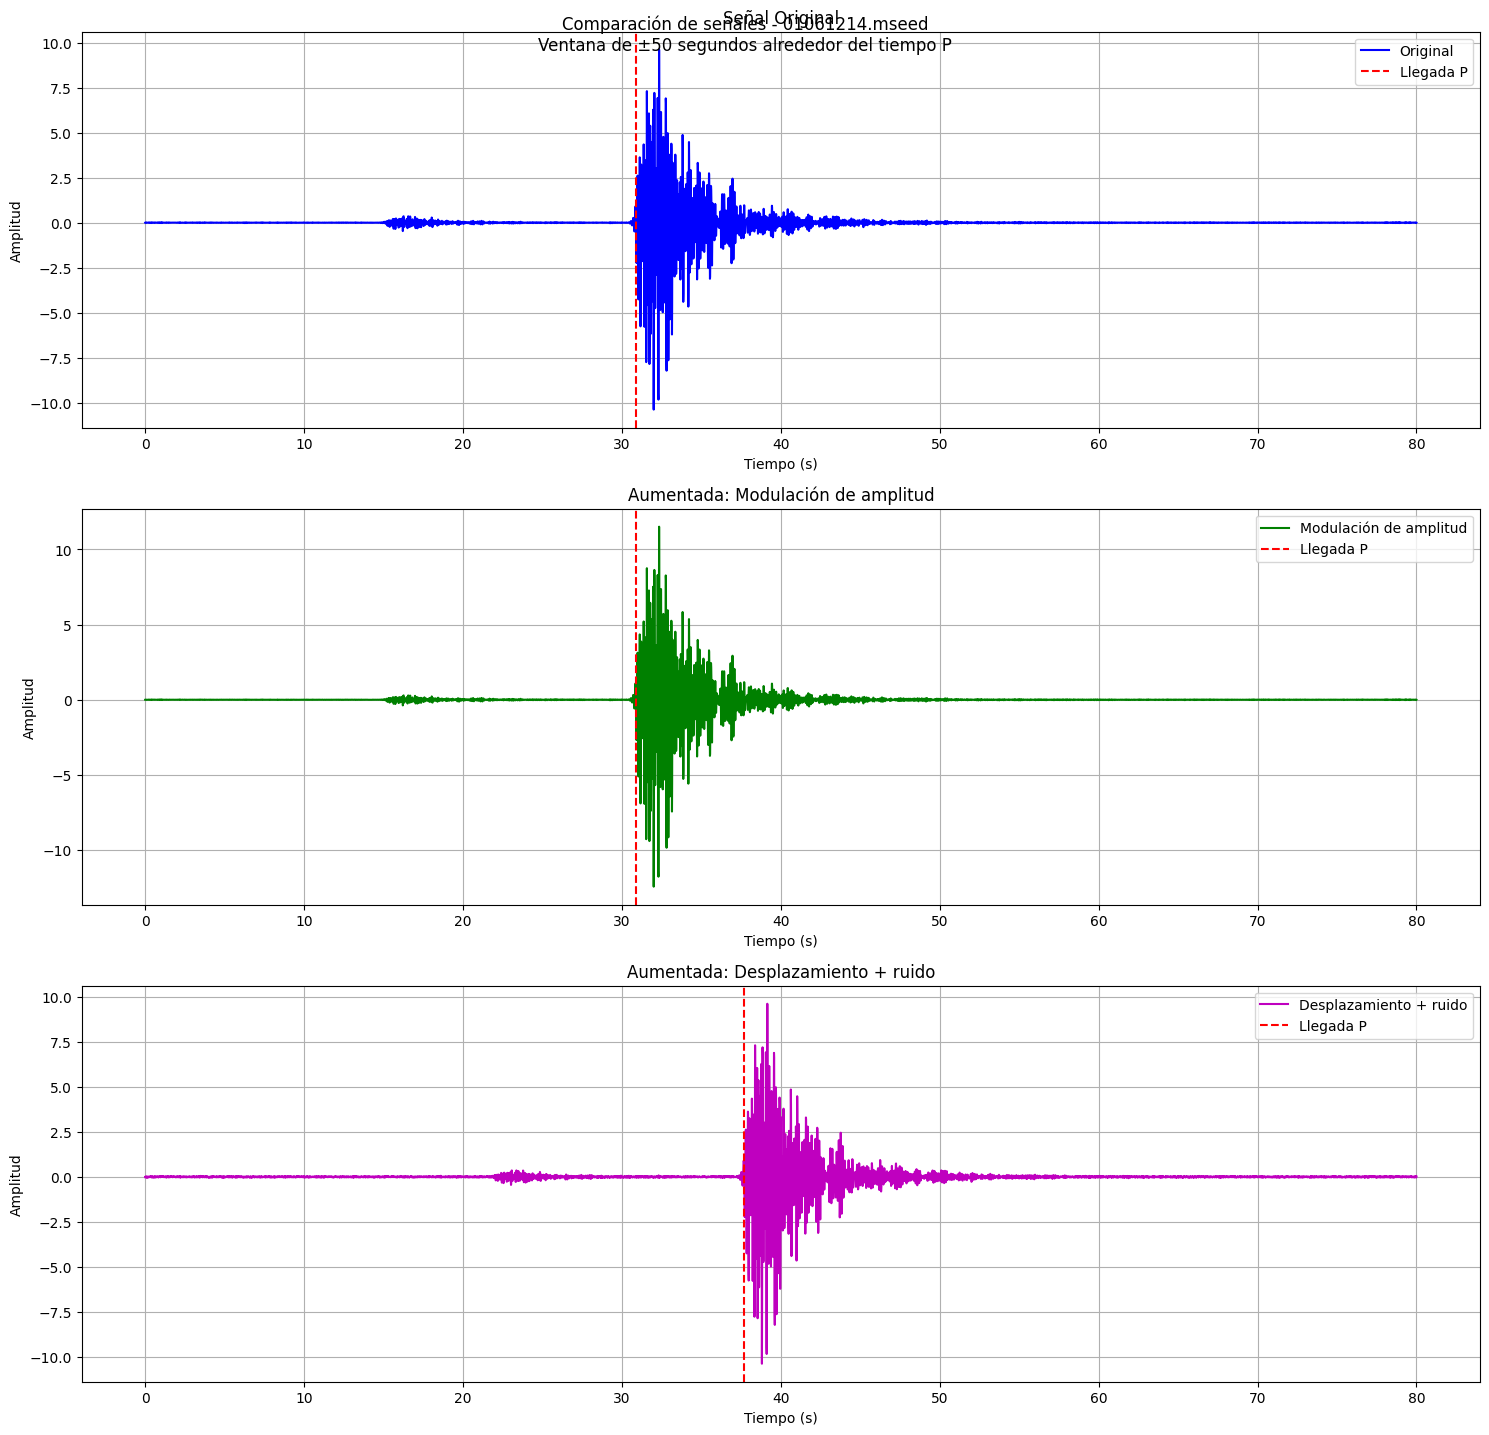


Estadísticas de las señales:
Original:
  Media: 0.000
  Desviación estándar: 0.734
  Tiempo P: 30.90 s

Modulación de amplitud:
  Media: 0.000
  Desviación estándar: 0.878
  Tiempo P: 30.90 s

Desplazamiento + ruido:
  Media: -0.000
  Desviación estándar: 0.734
  Tiempo P: 37.71 s
  Desplazamiento: 6.81 s

Rango de tiempo mostrado: 0.0s - 80.0s
Duración total mostrada: 80.0s

Creadas 2 versiones aumentadas


In [96]:
# Probar con un archivo de ejemplo
example_file = '01061214.mseed'
example_row = df[df['archivo'] == int(example_file[:8])]

if not example_row.empty:
    p_time = example_row.iloc[0]['lec_p']
    print(f"Procesando archivo: {example_file}")
    
    # Leer la señal para obtener el tiempo relativo
    st = read(os.path.join(train_data_path, example_file))
    relative_p_time = get_relative_p_time(st[0], p_time)
    print(f"Tiempo de llegada de onda P relativo: {relative_p_time:.2f} segundos")
    
    # Generar y visualizar las señales aumentadas
    plot_augmentation_comparison(example_file)
    
    # Guardar las señales aumentadas
    num_augmented = augment_single_file(example_file, p_time)
    print(f"\nCreadas {num_augmented} versiones aumentadas")
else:
    print("Archivo no encontrado en el CSV")

In [23]:
# function to move the files 

files = os.listdir(train_data_path)

def copy_files(df, source_path, dest_path):
    """
    Move files from source_path to dest_path based on the filenames in the dataframe.	
    """
    for index, row in df.iterrows():
        filename = row['filename']
        source_file = os.path.join(source_path, filename + '.mseed')
        dest_file = os.path.join(dest_path, filename + '.mseed')
        if os.path.exists(source_file):
            shutil.copy2(source_file, dest_file)
            print(f'Moved {source_file} to {dest_file}')
        else:
            print(f'File {source_file} does not exist')

df = pd.DataFrame(files, columns=['filename'])
df['filename'] = df['filename'].str.replace('.mseed', '') 
train_set, test_set = train_test_split(df, test_size=0.16, random_state=42)


In [28]:
# move val files 
# copy_files(test_set, train_data_path, val_data_path)

# move train files 
copy_files(train_set, train_data_path, train_augment_data_path)


Moved /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training/02121652.mseed to /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/train/02121652.mseed
Moved /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training/12091111.mseed to /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/train/12091111.mseed
Moved /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training/01210411.mseed to /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/train/01210411.mseed
Moved /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training/07011356.mseed to /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/train/07011356.mseed
Move

In [29]:
files_val = os.listdir(val_data_path)
print(f"Total files in val_data_path: {len(files_val)}")
files_training = os.listdir(train_data_path)
print(f"Total files in train_data_path: {len(files_training)}")
files_testing = os.listdir(testing_data_path)
print(f"Total files in augmented_data_path: {len(files_testing)}")
files_augmented = os.listdir(train_augment_data_path)
print(f"Total files in augmented_data_path: {len(files_augmented)}")

Total files in val_data_path: 317
Total files in train_data_path: 1980
Total files in augmented_data_path: 496
Total files in augmented_data_path: 1663
